# Imports

In [8]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, interact_manual

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-2.5-flash-preview-05-20"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using hapi_data

Received! How can I help you today?


In [9]:
# custom
import sys
sys.path.append('../../../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

Hello!


# Benchmark

In [10]:
pressure_list = [300, 600, 900]
freq_list_2 = [20, 30, 40, 80, 90, 130, 170, 220, 300]

benchmark_path_2 = "./"
benchmark_noise_2 = "./noise-tests"

patterns = cp.create_regex_strings(pressure_list, freq_list_2)

test_bench_files = cp.dir_match_dict(benchmark_path_2, patterns) 
# pp.pprint(patterns)
# pp.pprint(test_bench_files)

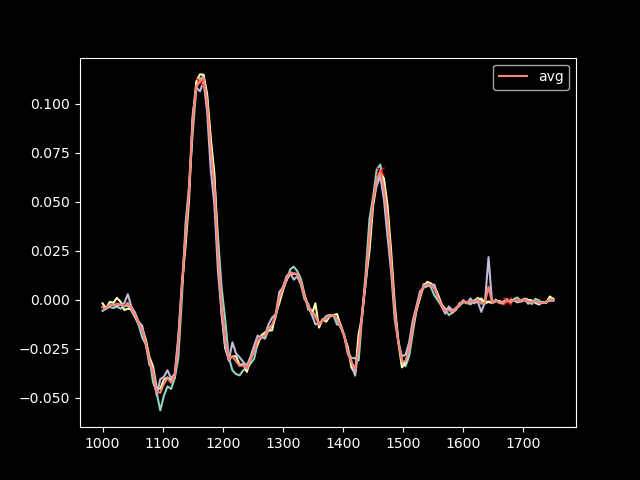

In [37]:


u1 = [1158.1, 1452.7]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 900
f = 20
bench_test_2 = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
# bench_test.self_test()
bench_test_2.add_wav(u1, u2)
bench_test_2.add_magnitude()
test_avg = bench_test_2.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget

plt.close()
plt.figure()
# 1st test
plt.plot(bench_test_2.spectra.spectra_list[0]['offset1'], bench_test_2.spectra.spectra_list[0]['H2_pnorm'])
plt.plot(bench_test_2.spectra.spectra_list[1]['offset1'], bench_test_2.spectra.spectra_list[1]['H2_pnorm'])
plt.plot(bench_test_2.spectra.spectra_list[2]['offset1'], bench_test_2.spectra.spectra_list[2]['H2_pnorm'])
plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')

# test magnitude
# plt.plot(test_avg['offset1'], test_avg["magnitude_pnorm"], label="magnitude")

plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()

# Signal

Uncomment below to see all the peaks used for bench

0    36.046578
Name: magnitude_pnorm, dtype: float64


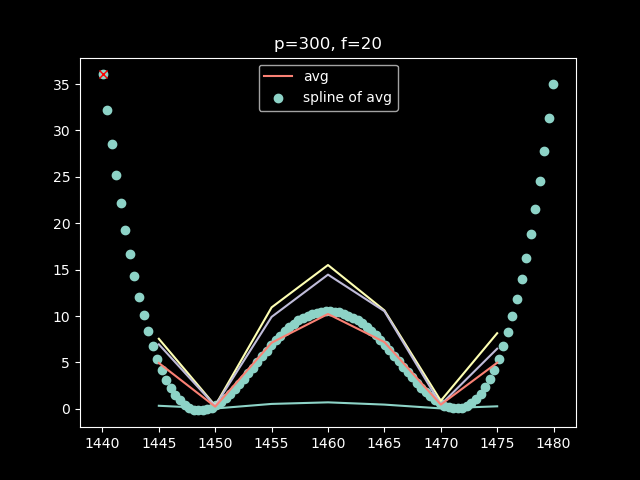

0    48.988825
Name: magnitude_pnorm, dtype: float64


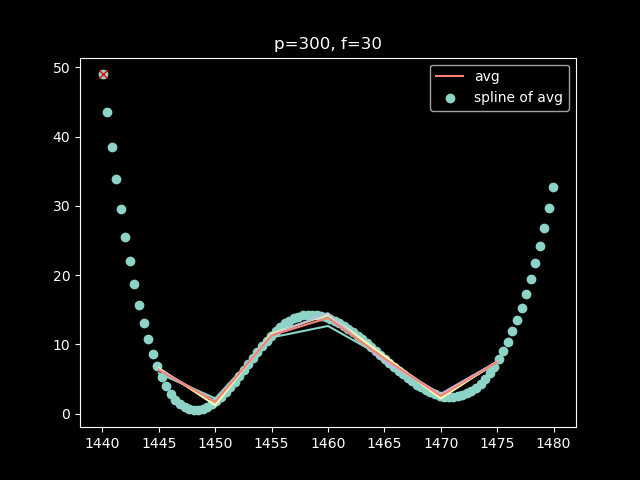

0    45.031339
Name: magnitude_pnorm, dtype: float64


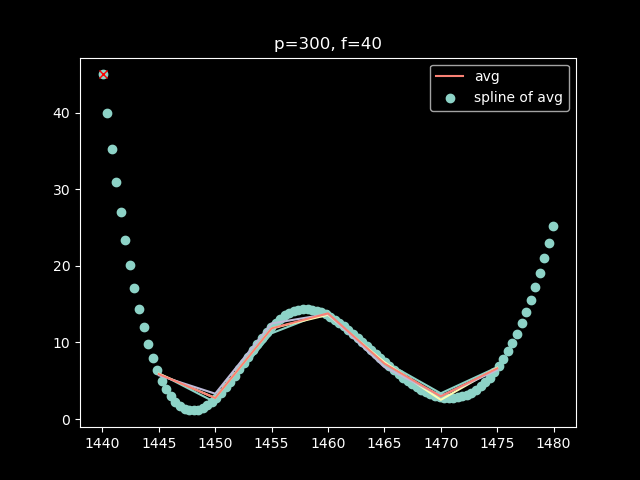

0    37.972261
Name: magnitude_pnorm, dtype: float64


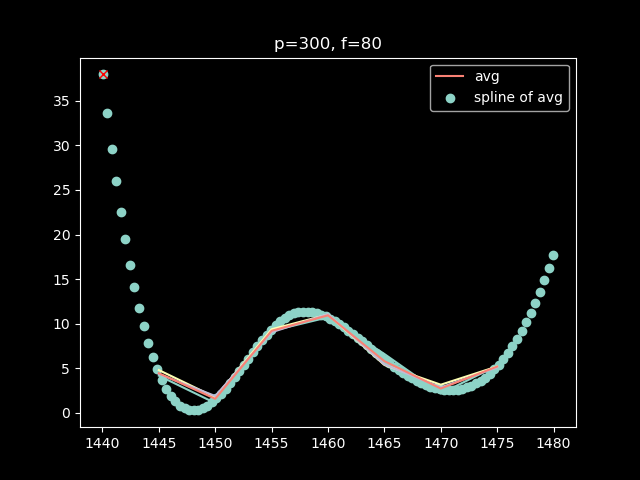

0    38.174797
Name: magnitude_pnorm, dtype: float64


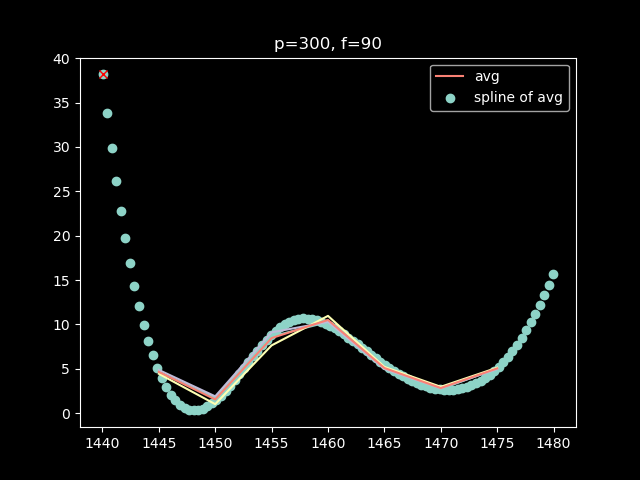

0    37.298171
Name: magnitude_pnorm, dtype: float64


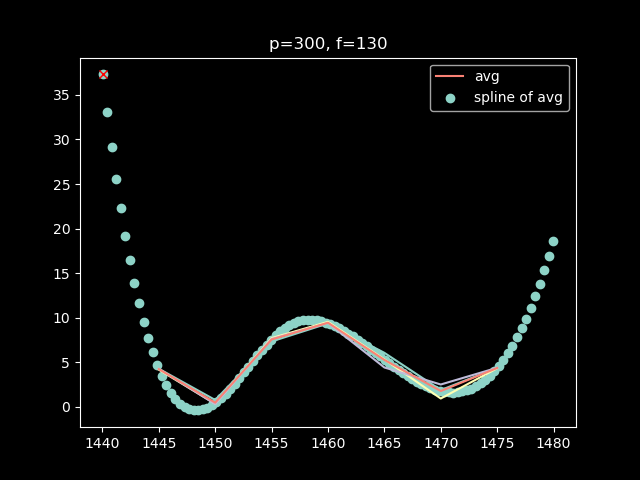

0    45.858133
Name: magnitude_pnorm, dtype: float64


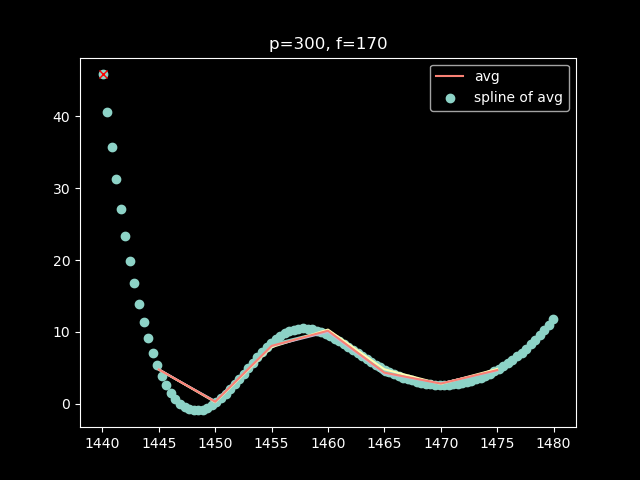

0    79.118069
Name: magnitude_pnorm, dtype: float64


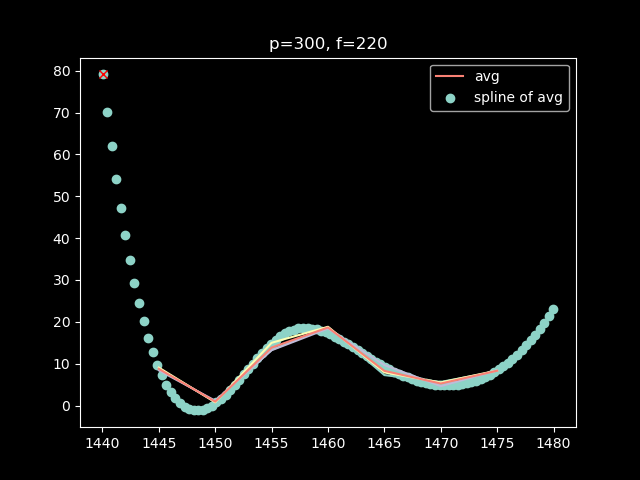

0    25.018799
Name: magnitude_pnorm, dtype: float64


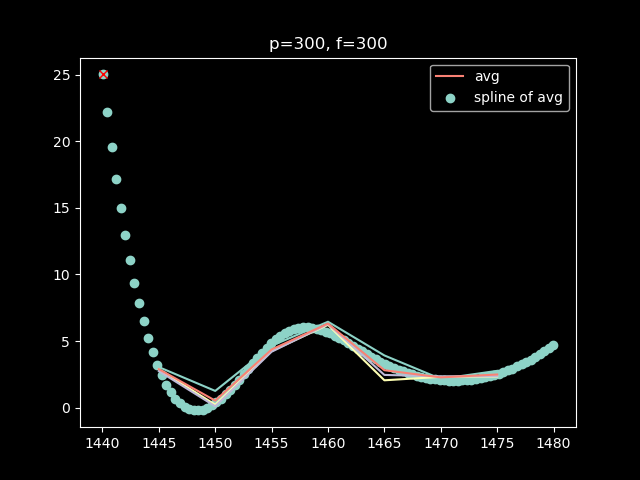

30    0.070538
Name: magnitude_pnorm, dtype: float64


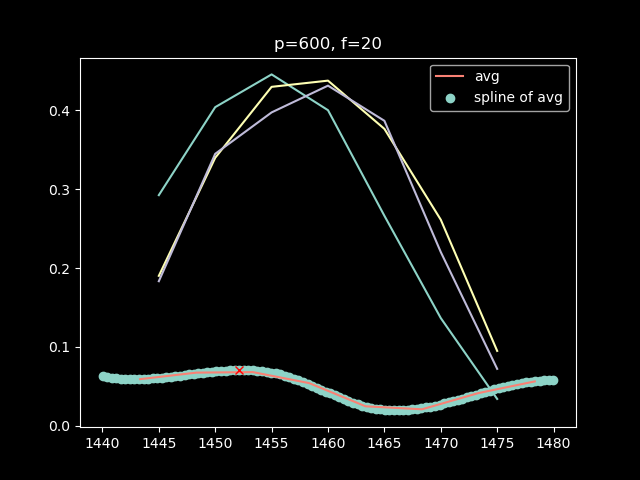

45    0.424402
Name: magnitude_pnorm, dtype: float64


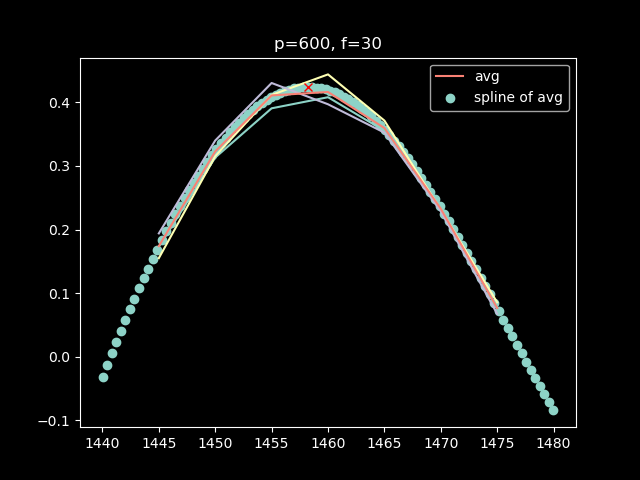

45    0.420247
Name: magnitude_pnorm, dtype: float64


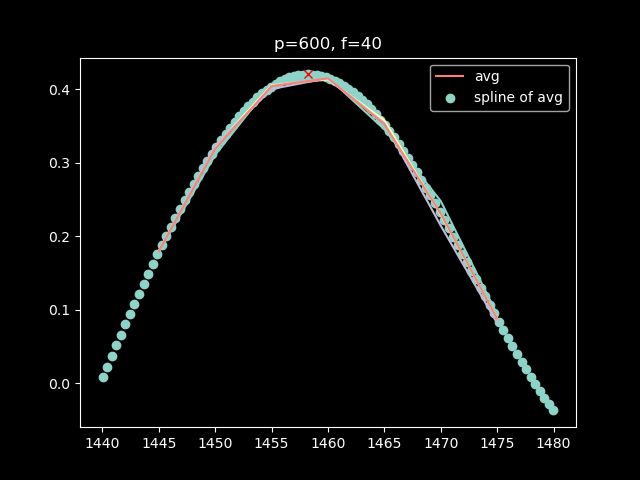

45    0.376217
Name: magnitude_pnorm, dtype: float64


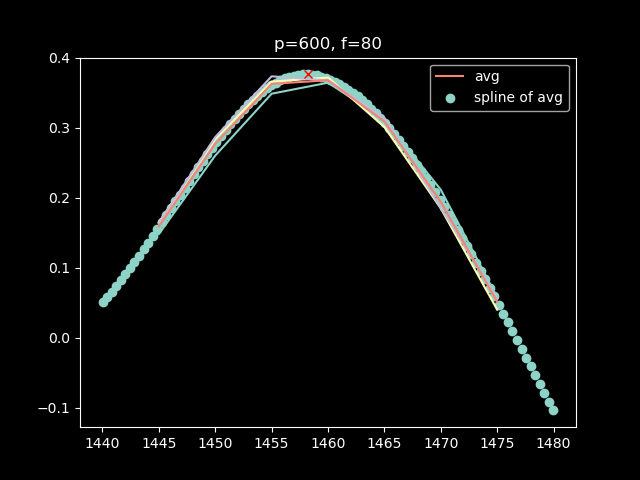

45    0.369124
Name: magnitude_pnorm, dtype: float64


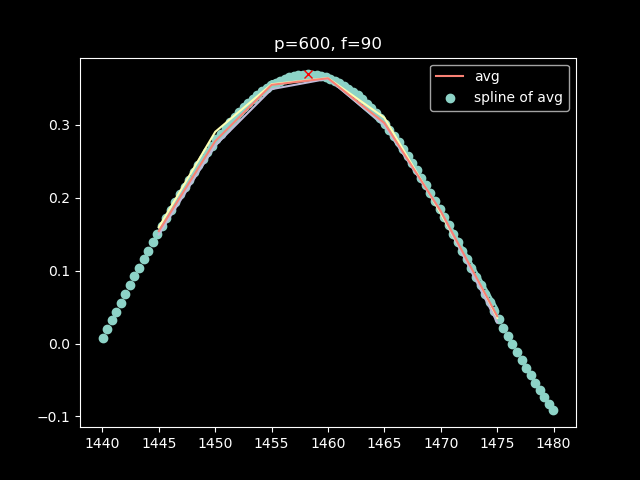

44    0.343915
Name: magnitude_pnorm, dtype: float64


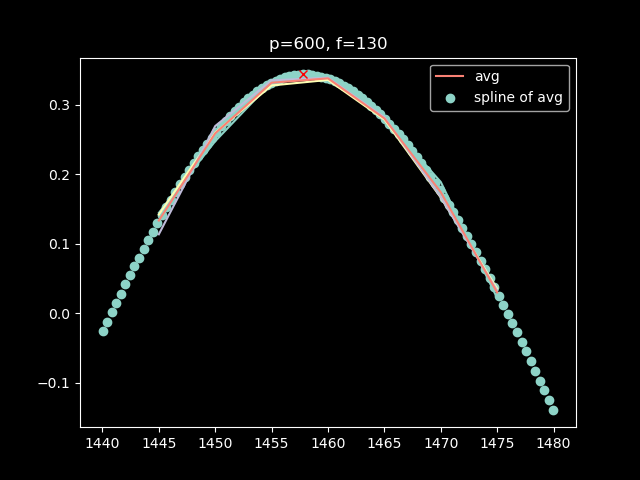

44    0.35591
Name: magnitude_pnorm, dtype: float64


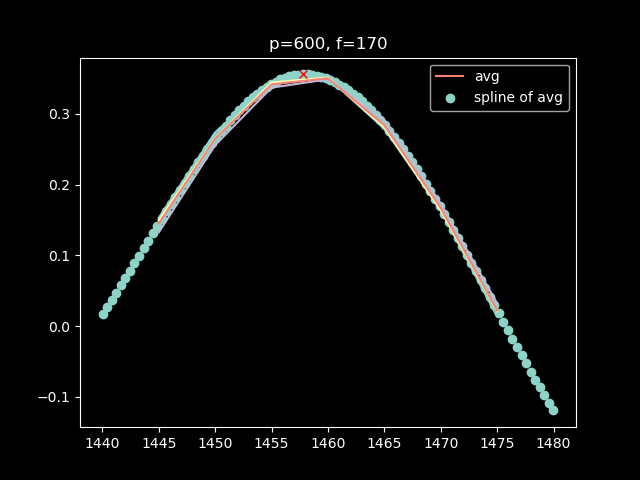

47    0.488504
Name: magnitude_pnorm, dtype: float64


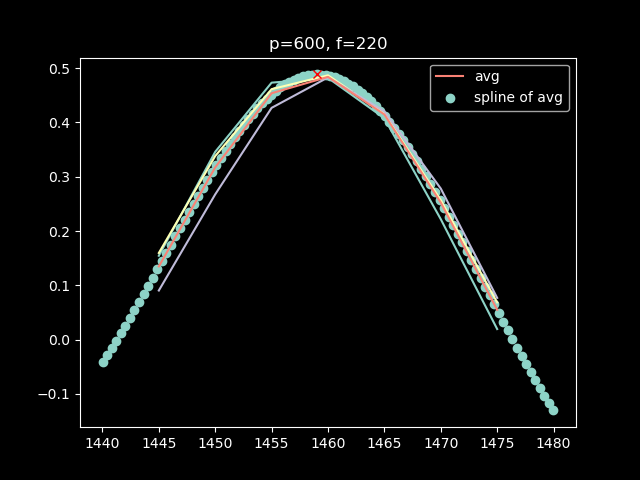

49    0.41919
Name: magnitude_pnorm, dtype: float64


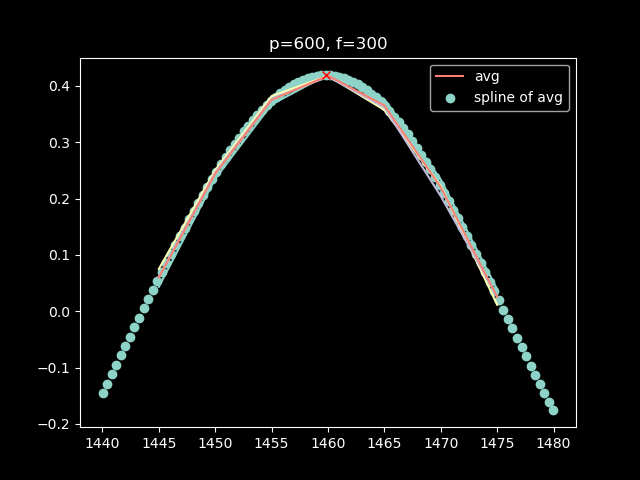

51    0.263592
Name: magnitude_pnorm, dtype: float64


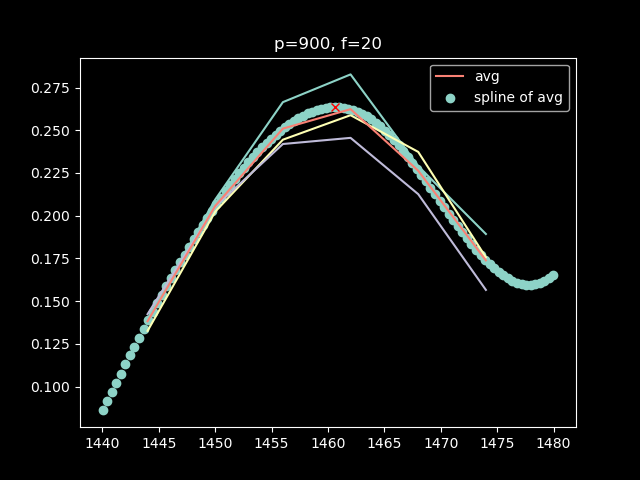

58    0.445923
Name: magnitude_pnorm, dtype: float64


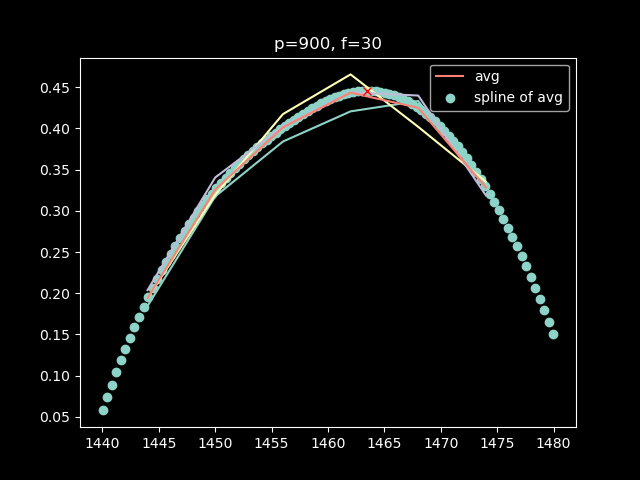

53    0.444434
Name: magnitude_pnorm, dtype: float64


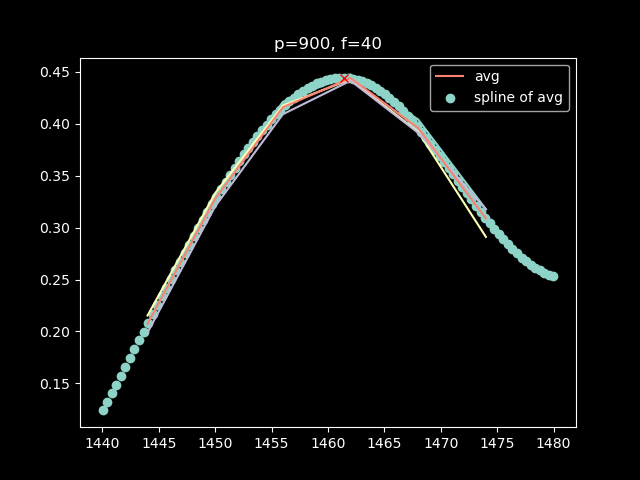

54    0.419241
Name: magnitude_pnorm, dtype: float64


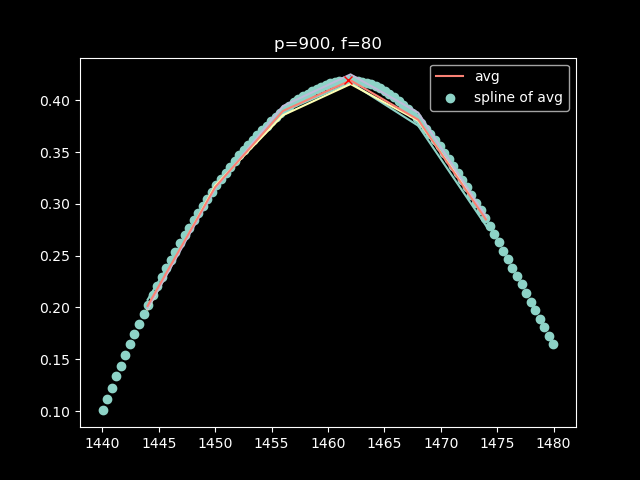

53    0.416142
Name: magnitude_pnorm, dtype: float64


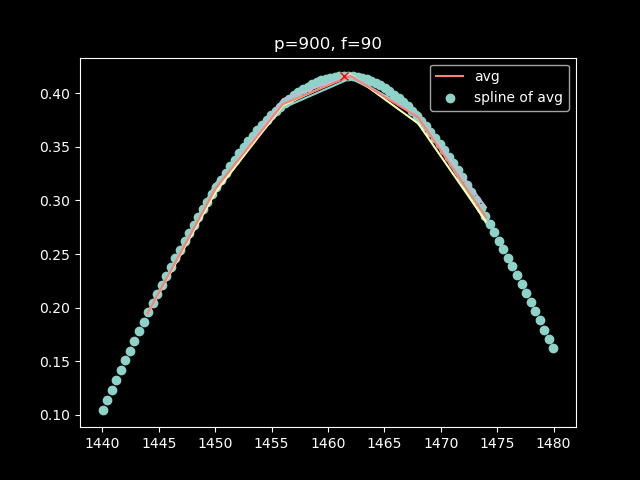

54    0.392615
Name: magnitude_pnorm, dtype: float64


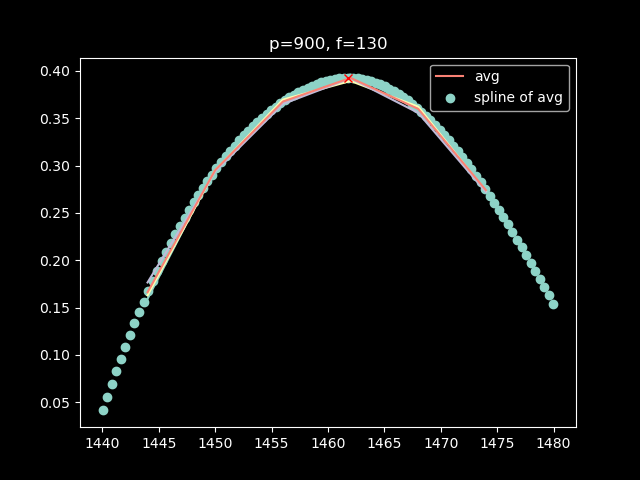

53    0.400973
Name: magnitude_pnorm, dtype: float64


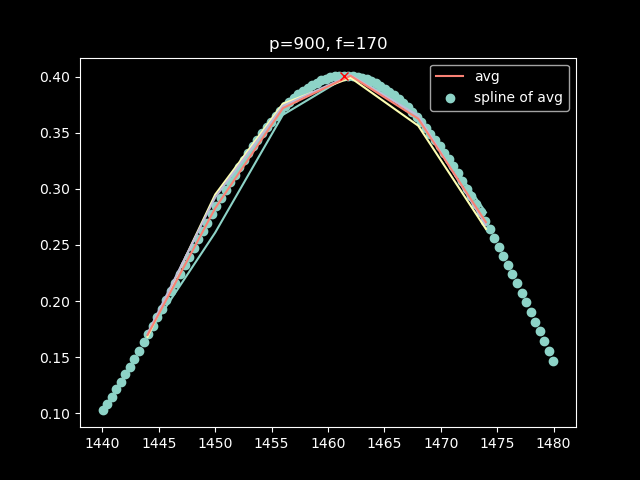

53    0.487123
Name: magnitude_pnorm, dtype: float64


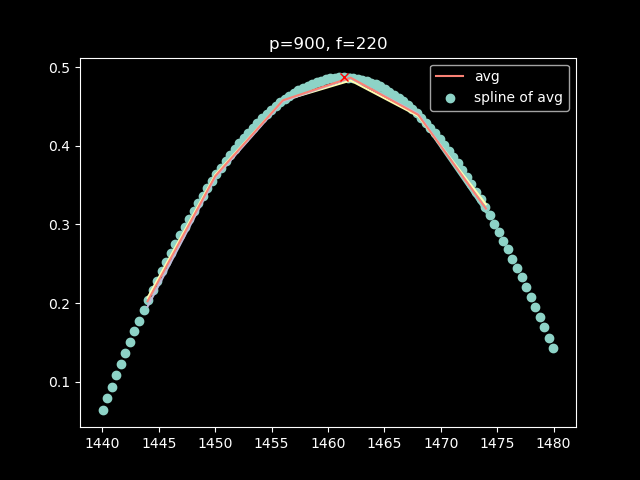

53    0.750633
Name: magnitude_pnorm, dtype: float64


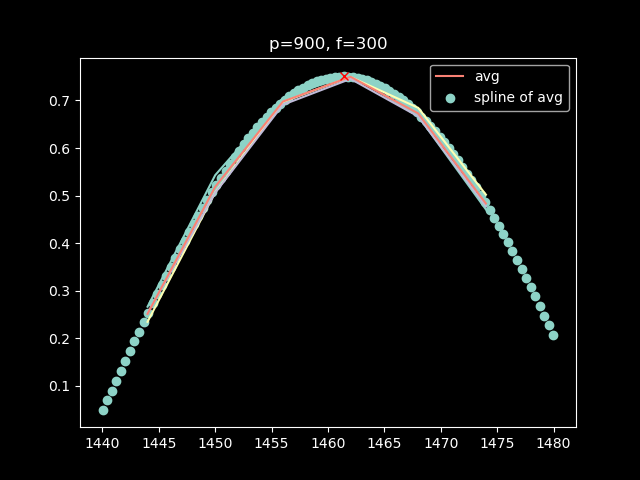

In [40]:
plt.close()
ps = [300, 600, 900]
fs = [20, 30, 40, 80, 90, 130, 170, 220, 300]
for p, f in itertools.product(ps, fs):
    bench_test = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
    bench_test.add_magnitude()
    peak_start = 1440
    peak_end = 1480
    peak = bench_test.get_window(peak_start, peak_end)
    peak_spline = bench_test.get_spline_of_window(n_spectrum=-1,
                                                  n_knots=6,
                                                  colx="offset1",
                                                  coly="magnitude_pnorm",
                                                  start=peak_start,
                                                  end=peak_end)
    # print(peak_spline[1])
    print(peak_spline[-1])
    plt.figure()
    plt.plot(peak[0]['offset1'], peak[0]['magnitude_pnorm'])
    plt.plot(peak[1]['offset1'], peak[1]["magnitude_pnorm"])
    plt.plot(peak[2]['offset1'], peak[2]["magnitude_pnorm"])
    plt.plot(peak[3]['offset1'], peak[3]['magnitude_pnorm'], label='avg')
    plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['magnitude_pnorm'], label='spline of avg')
    plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['magnitude_pnorm'], 'rx')
    plt.legend()
    plt.title(f"p={p}, f={f}")
    plt.show()

# Noise

In [ ]:
# bench_noise_300_2 = CEPAS_noise_info(benchmark_noise_2, 300)
# bench_noise_600_2 = CEPAS_noise_info(benchmark_noise_2, 600)
# bench_noise_900_2 = CEPAS_noise_info(benchmark_noise_2, 900)


# # bench_noise_300 = CEPAS_noise_info(benchmark_noise, 300, 2)
# # bench_noise_600 = CEPAS_noise_info(benchmark_noise, 600, 2)
# # bench_noise_900 = CEPAS_noise_info(benchmark_noise, 900, 2)
# print(f"{np.format_float_scientific(bench_noise_300_2.get_noise_at(f), precision=3)}")
# plt.close()
# plt.figure(figsize=(11, 5))
# plt.subplot(131)
# plt.title("$300\\ \\text{mbar}$")
# plt.xlabel('Frequency, Hz')
# plt.ylabel('Intensity, arb.u.')
# plt.plot(bench_noise_300_2.spectrum['freq'], bench_noise_300_2.spectrum['intensity'])
# plt.subplot(132)
# plt.title("$600\\ \\text{mbar}$")
# plt.xlabel('Frequency, Hz')
# plt.ylabel('Intensity, arb.u.')
# plt.plot(bench_noise_600_2.spectrum['freq'], bench_noise_600_2.spectrum['intensity'])
# plt.subplot(133)
# plt.title("$900\\ \\text{mbar}$")
# plt.xlabel('Frequency, Hz')
# plt.ylabel('Intensity, arb.u.')
# plt.plot(bench_noise_900_2.spectrum['freq'], bench_noise_900_2.spectrum['intensity'])
# plt.tight_layout()
# plt.show()